In [1]:
# Data handling
import pandas as pd 
import numpy as np
import time

# Plotting
import seaborn as sns 
sns.set(style = "white")
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
%matplotlib inline
# TS plots
import scipy.stats as scs

# Statistical analysis and modeling
import math
from scipy import stats 
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.linear_model import LassoLarsIC, Lasso, Ridge, RidgeCV, LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import scale 

# Hide warnings
import warnings
warnings.simplefilter("ignore")

# Table of Content 

<font size="4" face="Calibri"> __[Task 1. Autoregressive models for weekly sales](#Task-1.-Autoregressive-models-for-weekly-sales)__ 
  
> [Variables used in the study](#Variables-used-in-the-study)

[Part 1a: Descriptive statistics for the data](#Descriptive-statistics-for-the-data)

> [Data](#Data)

> [Continuous variables - sales and price histograms](#Continuous-variables---sales-and-price-histograms)

> [Continuous variables - sales and price line plots](#Continuous-variables---sales-and-price-line-plots)

> [Categorical variables - promotions bar plots](#Categorical-variables---promotions-bar-plots)

[Part 1aa: Validating key linear regression assumptions](#Validating-key-linear-regression-assumptions)

> [Residual scatter plot](#Residual-scatter-plot)

> [Correlation matrix](#Correlation-matrix)

> [Residual normality plot](#Residual-normality-plot)
  
> [Log-transformed sales and price data](#Log-transformed-sales-and-price-data)

[Part 1b: Simple AR model for sales with lags 1 and 2](#Simple-AR-model-for-sales-with-lags-1-and-2)

[Part 1c: Simulate trajectories of AR models](#Simulate-trajectories-of-AR-models)

__[Task 2. Modeling sales and promotion effectiveness](#Task-2.-Modeling-sales-and-promotion-effectiveness)__

[Part 2d: Add lags to all independent variables](#Add-lags-to-all-independent-variables)

[Part 2e: Divide data to training and testing sets](#Divide-data-to-training-and-testing-sets)

[Part 2f: Use regularized regressions for building models for weekly sales](#Use-regularized-regressions-for-building-models-for-weekly-sales)

> [Lasso regression model](#Lasso-regression-model)

> [Ridge regression model](#Ridge-regression-model)

[Part 2g: Re-estimation with OLS model and comparison between OLS and Lasso regression model](#Re-estimation-with-OLS-model-and-comparison-between-OLS-and-Lasso-regression-model)

[Part 2h: Which campaigns to run for the next four weeks](#Which-campaigns-to-run-for-the-next-four-weeks)

__[End notes](#End-notes)__
    


***

### Variables used in the study

- sales (weekly)
- price (used in the given supermarket)
- CP – coupon promotion only
- DP – major display promotion only
- TP – combined promotion
- mail campaigns at 4 different sites (count variables)

# Task 1. Autoregressive models for weekly sales 



### Part 1a: 
### Descriptive statistics for the data

In [23]:
df = pd.read_csv("heinz-sales.txt", sep = ",")
print(df.shape)
df.head(5)

(123, 9)


,sales,price,TP,CP,DP,mail_campaign.1,mail_campaign.2,mail_campaign.3,mail_campaign.4
0,62.109988,1.090000,0,0,0,5,4,5,4
1,38.860178,0.911505,0,0,0,8,5,8,6
2,67.987651,0.976296,0,0,0,6,5,4,6
3,79.657550,0.918906,0,0,0,6,4,5,3
4,55.455456,0.937487,0,0,0,1,3,3,3


In [42]:
tyyli = []
for i in df.iloc[[1,5],:]:
    tyyli.append('hiihtotyyli_1')
for i in df.iloc[[5,10],:]:
    tyyli.append('hiihtotyyli _2')

In [43]:
df2 = pd.DataFrame(tyyli, columns = ['uus'])

In [44]:
df_3 = pd.concat([df,df2], axis = 1)

In [46]:
df_3.head()

,sales,price,TP,CP,DP,mail_campaign.1,mail_campaign.2,mail_campaign.3,mail_campaign.4,uus
0,62.109988,1.090000,0,0,0,5,4,5,4,hiihtotyyli_1
1,38.860178,0.911505,0,0,0,8,5,8,6,hiihtotyyli_1
2,67.987651,0.976296,0,0,0,6,5,4,6,hiihtotyyli_1
3,79.657550,0.918906,0,0,0,6,4,5,3,hiihtotyyli_1
4,55.455456,0.937487,0,0,0,1,3,3,3,hiihtotyyli_1


In [48]:
filtered_df = df_3[df_3['uus'].notnull()]

In [50]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 10 columns):
sales              18 non-null float64
price              18 non-null float64
TP                 18 non-null int64
CP                 18 non-null int64
DP                 18 non-null int64
mail_campaign.1    18 non-null int64
mail_campaign.2    18 non-null int64
mail_campaign.3    18 non-null int64
mail_campaign.4    18 non-null int64
uus                18 non-null object
dtypes: float64(2), int64(7), object(1)
memory usage: 1.5+ KB


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 9 columns):
sales              123 non-null float64
price              123 non-null float64
TP                 123 non-null int64
CP                 123 non-null int64
DP                 123 non-null int64
mail_campaign.1    123 non-null int64
mail_campaign.2    123 non-null int64
mail_campaign.3    123 non-null int64
mail_campaign.4    123 non-null int64
dtypes: float64(2), int64(7)
memory usage: 8.7 KB


### Data
- 123 entries
- Has no missing values
- Has no NaN values 
- Has only integer and float values

***

### Continuous variables - sales and price histograms 

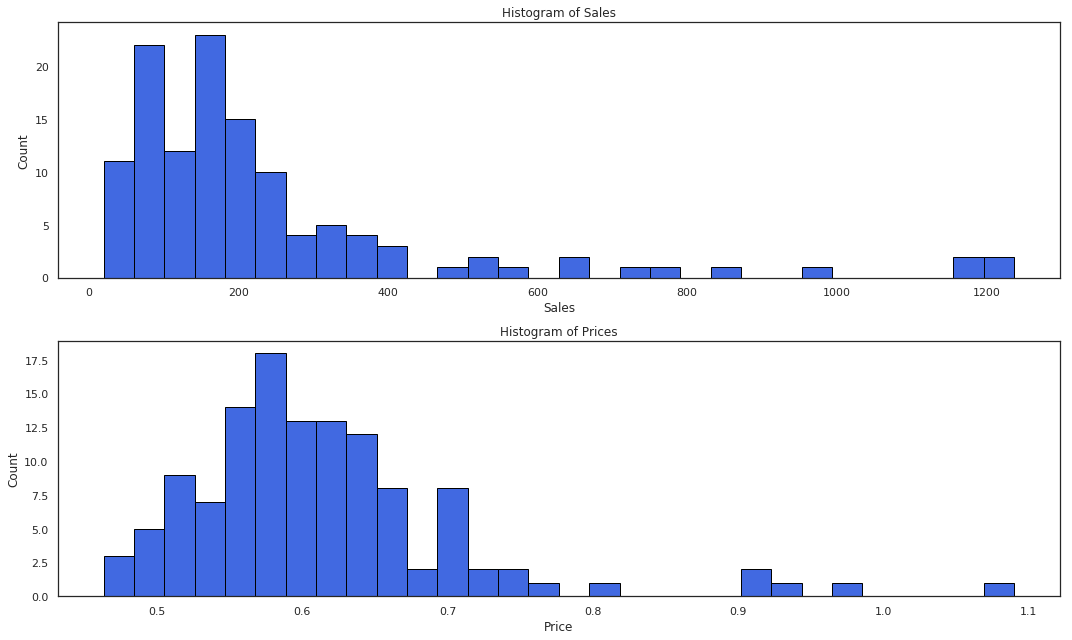

In [5]:
fig = plt.figure(figsize=(15,9))

hist_sales = plt.subplot(2,1,1) 
hist_sales.hist(df["sales"], bins = 30, ec = "black", color = "royalblue")
plt.xlabel("Sales")
plt.ylabel("Count")
plt.title("Histogram of Sales")

hist_price = plt.subplot(2,1,2)
hist_price.hist(df["price"], bins = 30, ec = "black", color = "royalblue")
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Histogram of Prices")

plt.tight_layout()

These histograms indicate that both sales and price are non-normally distributed and instead they follow a log-normal distribution. For further stationarity analysis, I am going to check how these variables behave against time.

### Continuous variables - sales and price line plots

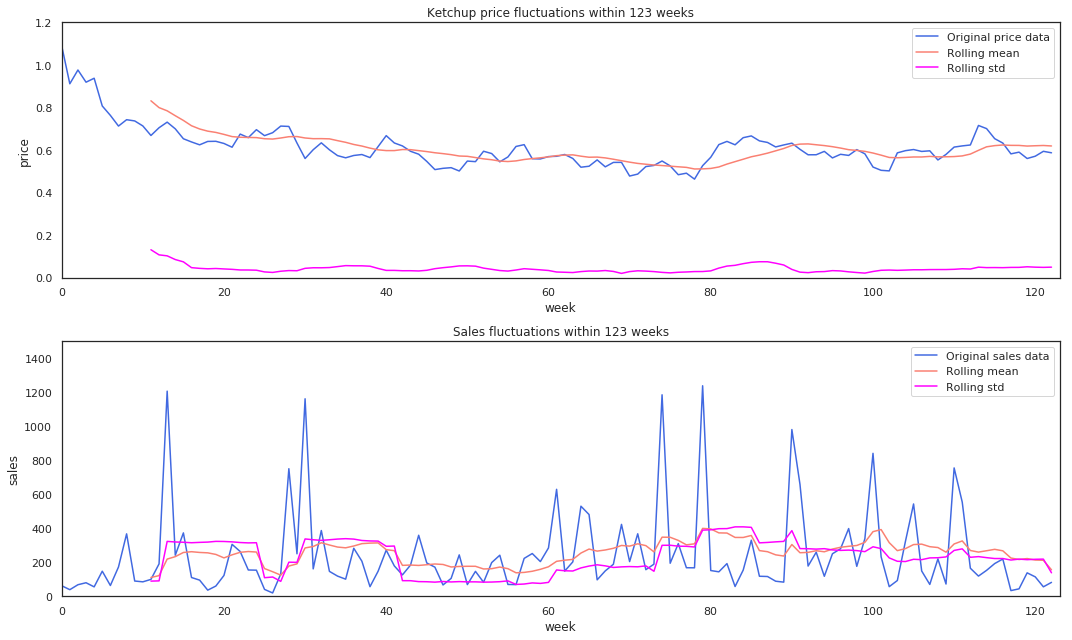

In [6]:
df["week"] = [i for i in range(123)]
plt.figure(figsize = (15, 9))

for n, x_ax, y_ax, mu, std, title, l1, l2, l3, x_la, y_la, ylim in [(1, 
                                                                     df.loc[:,"week"], 
                                                                     df.loc[:,"price"], 
                                                                     df.loc[:,"price"].rolling(12).mean(),
                                                                     df.loc[:,"price"].rolling(12).std(),
                                                                     "Ketchup price fluctuations within 123 weeks",
                                                                     "Original price data",
                                                                     "Rolling mean",
                                                                     "Rolling std",                                                                                                                                        
                                                                     "week", "price", [0,1.2]),
                                                                    
                                                                     (2, 
                                                                      df.loc[:,"week"], 
                                                                      df.loc[:,"sales"], 
                                                                      df.loc[:,"sales"].rolling(12).mean(),
                                                                      df.loc[:,"sales"].rolling(12).std(),
                                                                      "Sales fluctuations within 123 weeks", 
                                                                      "Original sales data",
                                                                      "Rolling mean",
                                                                      "Rolling std",
                                                                      "week", "sales", [0,1500])]:
    
    plt.subplot(2,1, n)
    plt.plot(x_ax, y_ax, color = "royalblue", label = l1)
    plt.plot(mu, color = "salmon", label = l2)
    plt.plot(std, color = "magenta", label = l3)
    
    plt.legend(loc = "best")
    plt.title(title)
    plt.xlabel(x_la)
    plt.ylabel(y_la)
    plt.ylim(ylim)
    plt.xlim(0,123)
    
plt.tight_layout()   
plt.show()

__Price:__
 - The price of ketchup has exponentially decreased within approxiamtely 2.5 years 
 - The rolling meand and standard deviations seem to be constant through time 
 
 
__Sales:__
 - The rolling mean and standard deviation seem to be fairly constant through time regardless of the few downward and upward trends in the data. It would seem that there is no seasonality in the sales amount
 - The density in the spread of the data seems to be constant through time indicating a constant covariance


### To further validate the stationarity assumption, let's check the ADF statistic


In [7]:
for value in [(df["sales"].values), np.log(df["sales"]).values]:

    adf_result = adfuller(value)
    print("ADF Statistic: {:.3f}".format(adf_result[0]))
    print("p-value: {:.3f}".format(adf_result[1]))

ADF Statistic: -10.089
p-value: 0.000
ADF Statistic: -8.088
p-value: 0.000


For both cases the p-value < 0.05 and is practically zero, thus we reject the null hypothesis of non-stationarity and accept the alternative hypothesis suggesting that the time series does not have a unit root and that it is indeed stationary.

***

### Categorical variables - promotions bar plots

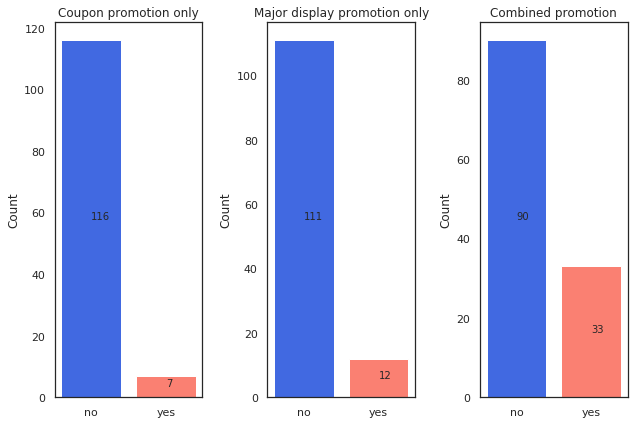

In [8]:
plt.figure(figsize = (9, 6))
for column, n, bar1, bar2, title in [(df["TP"], 1, "no", "yes", "Coupon promotion only"),
                                     (df["CP"], 2, "no", "yes", "Major display promotion only"),
                                     (df["DP"], 3, "no", "yes", "Combined promotion")]:
    
    keys, counts = np.unique(column, return_counts = True)
    plt.subplot(1,3, n)
    plt.bar([bar1, bar2], counts, color = ["royalblue", "salmon"]) 
    plt.title(title)
    plt.ylabel("Count")
    plt.text([bar1], counts[0]/2, counts[0]) 
    plt.text([bar2], counts[1]/2, counts[1]) 

plt.tight_layout()
plt.show()



 - This plot shows that among all promotion types, combined promotion is by far the most popular one. In addition the total amount of promotions across the 123 weeks is quite small.

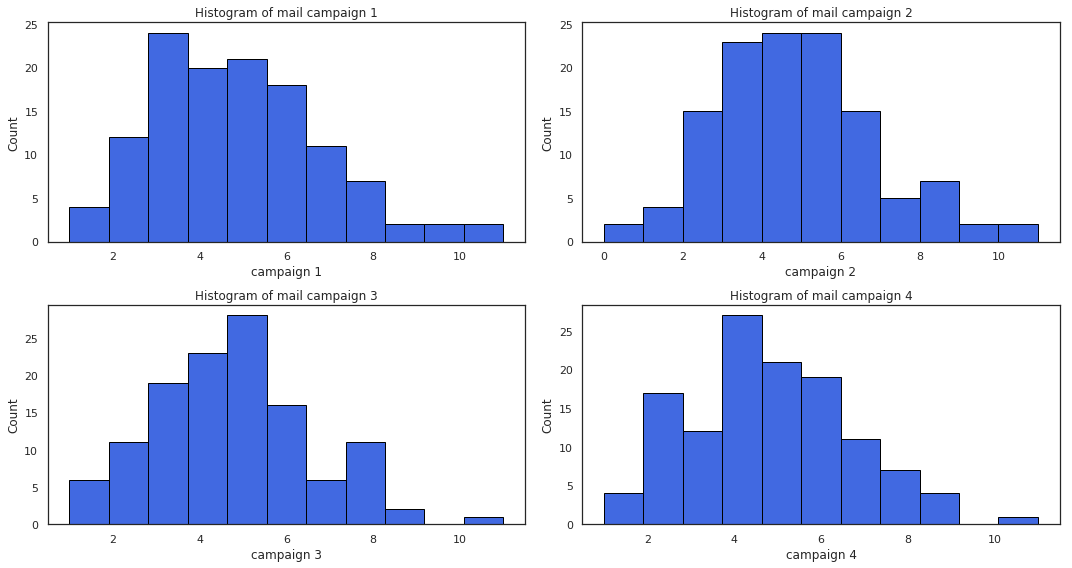

In [9]:
plt.figure(figsize = (15, 8))
for column, n, bins, campaign, title in [(df["mail_campaign.1"], 1, 11, "campaign 1", "Histogram of mail campaign 1"),
                                         (df["mail_campaign.2"], 2, 11, "campaign 2", "Histogram of mail campaign 2"),
                                         (df["mail_campaign.3"], 3, 11, "campaign 3", "Histogram of mail campaign 3"),
                                         (df["mail_campaign.4"], 4, 11, "campaign 4", "Histogram of mail campaign 4")]:
    
    plt.subplot(2,2,n) 
    plt.hist(column, bins = bins, ec = "black", color = "royalblue")
    plt.xlabel(campaign)
    plt.ylabel("Count")
    plt.title(title)
    
plt.tight_layout()
plt.show()

The amount of campaign seems to be fairly normally distributed. To address the log-normally distributed sales and price data (as shown above), I will use log-transformed sales and price data from this point forward. 

***

### Part 1aa 
### Validating key linear regression assumptions

- Residual plot for testing linearity and constant variance also known as homoscedasticity
- Correlation matrix for testing the assumptions of collinearity
- Q-Q plot for testing the assumptions of normality

### Residual scatter plot

Text(0.5,1,'Residual scatter plot')

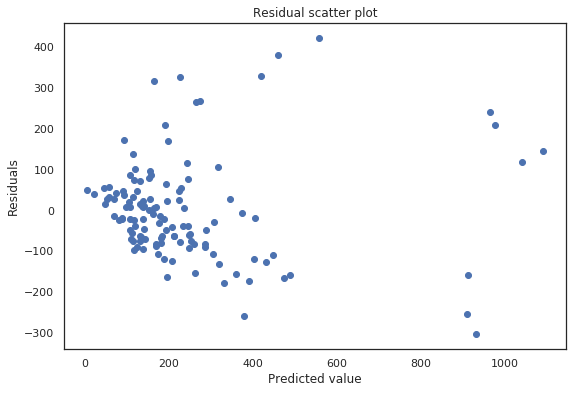

In [10]:
df.rename(columns = {"mail_campaign.1": "mail_campaign1",
                     "mail_campaign.2": "mail_campaign2",
                     "mail_campaign.3": "mail_campaign3",
                     "mail_campaign.4": "mail_campaign4"},inplace = True)

reg = smf.ols("sales ~ price + TP + CP + DP + mail_campaign1 + mail_campaign2 +\
               mail_campaign3 + mail_campaign4", data=df).fit()

pred_val = reg.fittedvalues.copy()
true_val = df["sales"].values.copy()
residual = true_val - pred_val

fig, ax = plt.subplots(figsize=(9,6))
_ = ax.scatter(pred_val, residual)
ax.set_xlabel("Predicted value")
ax.set_ylabel("Residuals")
ax.set_title("Residual scatter plot")


Examination of residuals scatterplots provide a test of assumptions of homoscedasticity and linearity, where e = y - ŷ. __This graph indicates a violation of homoscedasticity, as the residuals display triangle shaped pattern. Furthermore, linear relationship is not entirely evident__.

Violations
 - Linearity: erroneous β-coefficients and hence errouneous predictions
 - homoscedasticity: heteroscedasticity - confidence intervals of predictions tend to be too wide or narrow

***

### Correlation matrix

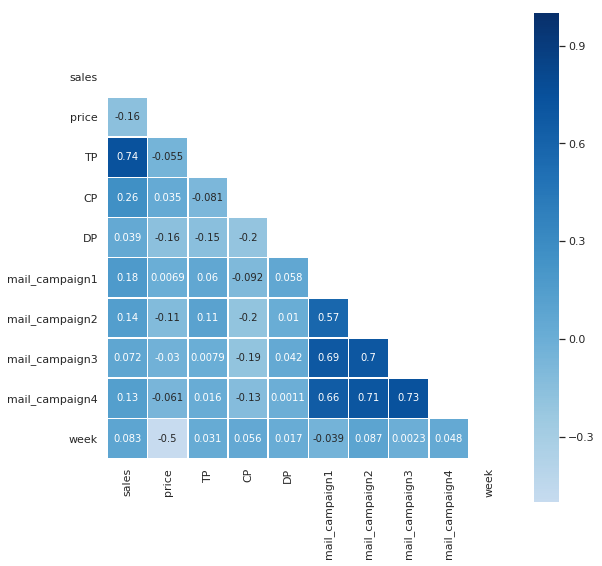

In [11]:
# Set up the matplotlib figure 
fig = plt.subplots(figsize = (9,9))

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask = mask, square = True, cbar = True, annot = True, 
            linewidths = 0.5, center=0, cmap = "Blues", annot_kws = {"size": 10})
plt.show()

- I constrain the acceptable pairwise correlation coefficient to be smaller or equal than 0.85, and this graph shows no vioaltion of that. All good on this end.

***

### Residual normality plot

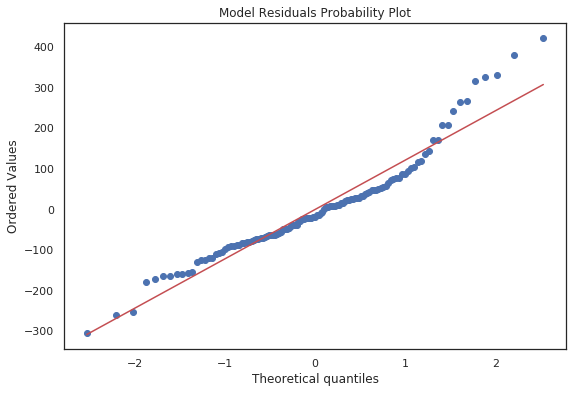

In [12]:
plt.figure(figsize = (9,6))
stats.probplot(reg.resid, plot = plt)
plt.title("Model Residuals Probability Plot")
plt.show()

- This plot indicates that the residuals are not normally distributed. Hence, normality does not seem to be safe assumption here.

***

### Log-transformed sales and price data

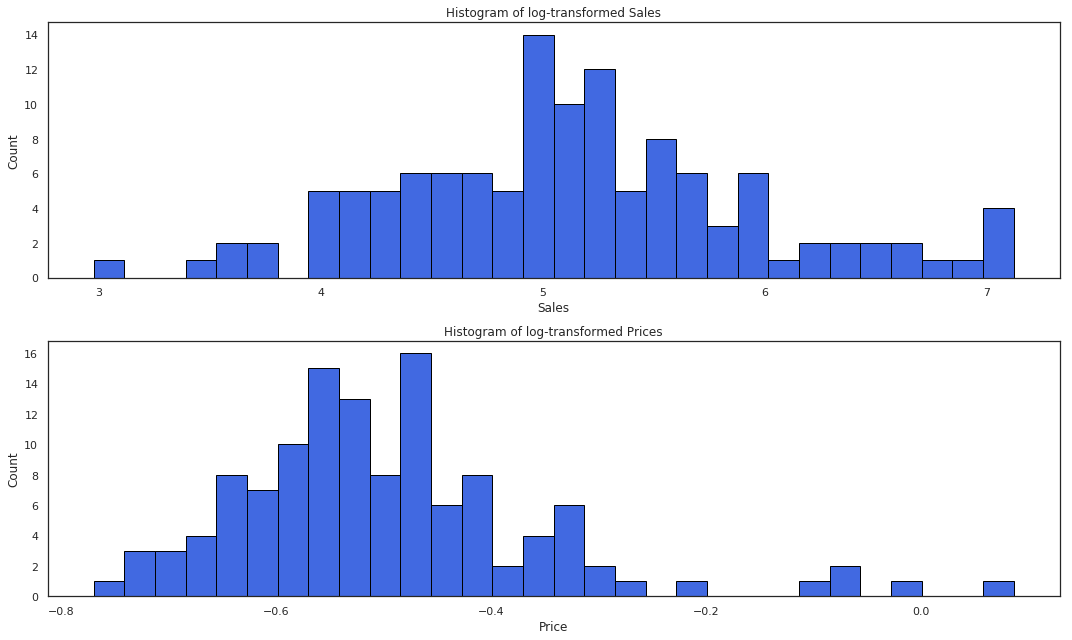

In [13]:
fig = plt.figure(figsize=(15,9))

log_sales = df["sales_log"] = np.log(df["sales"]) 
log_price = df["price_log"] = np.log(df["price"])

hist_sales = plt.subplot(2,1,1) 
hist_sales.hist(log_sales, bins = 30, ec = "black", color = "royalblue")
plt.xlabel("Sales")
plt.ylabel("Count")
plt.title("Histogram of log-transformed Sales")

hist_price = plt.subplot(2,1,2)
hist_price.hist(log_price, bins = 30, ec = "black", color = "royalblue")
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Histogram of log-transformed Prices")

plt.tight_layout()

We see that after log-transforming the sales and price data the distributions resemble more like normal distributions.

***

### Part 1b: 
### Simple AR model for sales with lags 1 and 2

In [14]:
#define embedding function
def embed(data, lag, var_name):
    embedded = data.rename(var_name)
    for i in range(1,lag+1):
        embedded = pd.concat([embedded, data.shift(i).rename(var_name+'_'+str(i))], axis=1)
    
    return embedded[lag::] 

In [15]:
lag = 2
dat = embed(df["sales_log"], lag, var_name = "sales_log")
print(dat.shape)
dat.head(3)

(121, 3)


,sales_log,sales_log_1,sales_log_2
2,4.219326,3.659970,4.128907
3,4.377737,4.219326,3.659970
4,4.015580,4.377737,4.219326


In [16]:
ar1 = smf.ols(formula = "sales_log ~ sales_log_1", data = dat).fit()
ar2 = smf.ols(formula = "sales_log ~ sales_log_1 + sales_log_2", data = dat).fit()

***

### Part 1c: 
### Simulate trajectories of AR models

In [17]:
N = len(dat["sales_log"])
y_0 = dat.iloc[0]["sales_log"]

# Intercepts for model 1 and 2 
ar1_constant = ar1.params[0]
ar2_constant = ar2.params[0]

# Coefficeints for model 1 and 2
ar1_phi = ar1.params[1]
ar2_phi = ar2.params[1:3]

# Residual standard error for model 1 and 2
ar1_sigma = np.sqrt(ar1.scale)
ar2_sigma = np.sqrt(ar2.scale)

# Simulating observations from AR(1) model
def simulate_from_ar1(ar1_constant, ar1_phi, ar1_sigma, N, initial_value = 0.0, random_state = 1):
                   
    y = np.zeros(N) 
    e = np.random.normal(size = N, scale = ar1_sigma)
    y[0] = initial_value
    for t in range(1,N): 
        y[t] = ar1_constant + ar1_phi*y[t-1] + e[t] 
    return y

# Simulating observations from AR(2) model
def simulate_from_ar2(ar2_constant, ar2_phi, ar2_sigma, N, initial_value = 0.0, random_state = 1):
    
    y = np.zeros(N) 
    e = np.random.normal(size = N, scale = ar2_sigma)
    y[0] = initial_value
    for t in range(1,N):
        y[t] = ar2_constant + ar2_phi[0]*y[t-1] + ar2_phi[1]*y[t-2] + e[t]
    return y

# Simulations 
ar1_sim = simulate_from_ar1(ar1_constant, ar1_phi, ar1_sigma, N, y_0)
ar2_sim = simulate_from_ar2(ar2_constant, ar2_phi, ar2_sigma, N, y_0)

In [18]:
def tsplot_comp(y1,y2, lags = None, figsize = (12, 8)):
    
    if not isinstance(y1, pd.Series):
        y1 = pd.Series(y1)
    if not isinstance(y2, pd.Series):
        y2 = pd.Series(y2)
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (2, 2)
        ts1_ax = plt.subplot2grid(layout, (0, 0))
        ts2_ax = plt.subplot2grid(layout, (1, 0))
        acf1_ax = plt.subplot2grid(layout, (0, 1))
        acf2_ax = plt.subplot2grid(layout, (1, 1))      
        
        y1.plot(ax = ts1_ax, title = "Simulated AR(1) trajectory")
        y2.plot(ax = ts2_ax, title = "Simulated AR(2) trajectory")
        smt.graphics.plot_acf(y1, lags = lags, ax = acf1_ax, alpha = 0.5)
        smt.graphics.plot_acf(y2, lags = lags, ax = acf2_ax, alpha = 0.5) 
        
        plt.tight_layout()

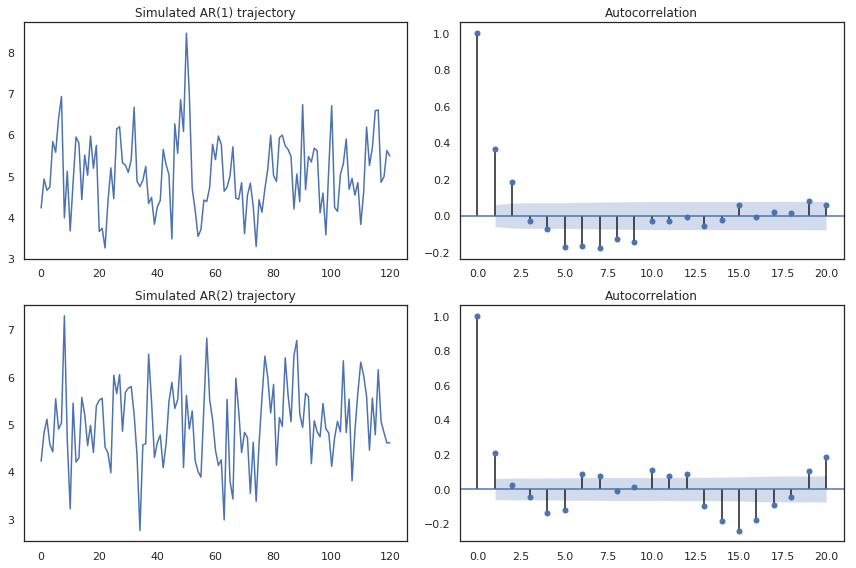

In [19]:
tsplot_comp(ar1_sim, ar2_sim, lags = 20)

The above simulated trajectories from the derived models provide further proof that after applying logarithmic operation for the dependent variable there is no any auto-correlation. 

In [20]:
def stat_test(alpha):
    
    print("\n")
    levene = stats.levene(ar1_sim, dat["sales_log"], center = "median")
    print(levene)
    levene2 = stats.levene(ar2_sim, dat["sales_log"], center = "median")
    print(levene2)
    
    if levene[1] > alpha or levene2[1] > alpha:
        print("Levenes test: Samples have equal variances, (fail to reject H0)")
    else:
        print("Levenes test: Samples have unequal variances, (reject H0)") 
    print("\n")
    
    ttest = scs.ttest_ind(ar1_sim, dat["sales_log"])
    print(ttest)
    ttest2 = scs.ttest_ind(ar2_sim, dat["sales_log"])
    print(ttest2)
    
    if ttest[1] > alpha or ttest[1] > alpha:
        print("T-test: difference between the true mean (μ) and the comparison value (m0) is equal to zero, (fail to reject H0)")
    else:
        print("T-test: some difference exists between the true mean (μ) and the comparison value (m0), (reject H0)")

In [21]:
stat_test(0.05)



LeveneResult(statistic=1.9762598726096725, pvalue=0.16107824615605404)
LeveneResult(statistic=0.34295690336795737, pvalue=0.55867766059610879)
Levenes test: Samples have equal variances, (fail to reject H0)


Ttest_indResult(statistic=-0.77261807115510495, pvalue=0.44050864551681201)
Ttest_indResult(statistic=-1.3296116631470534, pvalue=0.1849086150705137)
T-test: difference between the true mean (μ) and the comparison value (m0) is equal to zero, (fail to reject H0)


Based on the results, I can assume equal variances between the original data series and simulations (fail to reject null hypothesis at alpha = 0.05). Because the samples exhibit homogeneous variances, they are normally distributed (after log-modification) and they have a reasonably large n, I performed t-test to further validate the means of the data series and simulations. The results of the t-test also indicate a failure to reject the null hypothesis at 0.05 significance level. Thus, there is no significant difference in the means of the true data series and the simualted series and I can conclude that the simulated series are statistically identical to the true series of sales.

***

# Task 2. Modeling sales and promotion effectiveness


### Part 2d: 
### Add lags to all independent variables


In [22]:
# Define a new dataframe 
df1 = df.drop(["sales","price","week"], axis = 1)
print(df1.shape)
df1.head(3)

(123, 9)


,TP,CP,DP,mail_campaign1,mail_campaign2,mail_campaign3,mail_campaign4,sales_log,price_log
0,0,0,0,5,4,5,4,4.128907,0.086177
1,0,0,0,8,5,8,6,3.659970,-0.092659
2,0,0,0,6,5,4,6,4.219326,-0.023989


In [23]:
# Add lags to all independent variables 

lag_1 = 1
data_lagged1 = df1.shift(lag_1).add_suffix("_lag1")[lag_1::] # lag:: cuts out the first row 
lag_2 = 2
data_lagged2 = df1.shift(lag_2).add_suffix("_lag2")[lag_2::] # lag:: cuts out the first row 

data_lag_all = pd.concat([data_lagged1, data_lagged2], axis  = 1)
data_lag_all.dropna(axis = (0), inplace=True)

print(data_lag_all.shape)
data_lag_all.head(3)

(121, 18)


,TP_lag1,CP_lag1,DP_lag1,mail_campaign1_lag1,mail_campaign2_lag1,mail_campaign3_lag1,mail_campaign4_lag1,sales_log_lag1,price_log_lag1,TP_lag2,CP_lag2,DP_lag2,mail_campaign1_lag2,mail_campaign2_lag2,mail_campaign3_lag2,mail_campaign4_lag2,sales_log_lag2,price_log_lag2
2,0.0,0.0,0.0,8.0,5.0,8.0,6.0,3.659970,-0.092659,0.0,0.0,0.0,5.0,4.0,5.0,4.0,4.128907,0.086177
3,0.0,0.0,0.0,6.0,5.0,4.0,6.0,4.219326,-0.023989,0.0,0.0,0.0,8.0,5.0,8.0,6.0,3.659970,-0.092659
4,0.0,0.0,0.0,6.0,4.0,5.0,3.0,4.377737,-0.084571,0.0,0.0,0.0,6.0,5.0,4.0,6.0,4.219326,-0.023989


In [24]:
# Unite lag_0, lag_1 and lag_2 dataframes
data_final = pd.concat([data_lag_all, df1], axis = 1)
data_final = data_final.iloc[2:,:]
print(data_final.shape)
data_final.head(3)

(121, 27)


,TP_lag1,CP_lag1,DP_lag1,mail_campaign1_lag1,mail_campaign2_lag1,mail_campaign3_lag1,mail_campaign4_lag1,sales_log_lag1,price_log_lag1,TP_lag2,...,price_log_lag2,TP,CP,DP,mail_campaign1,mail_campaign2,mail_campaign3,mail_campaign4,sales_log,price_log
2,0.0,0.0,0.0,8.0,5.0,8.0,6.0,3.659970,-0.092659,0.0,...,0.086177,0,0,0,6,5,4,6,4.219326,-0.023989
3,0.0,0.0,0.0,6.0,5.0,4.0,6.0,4.219326,-0.023989,0.0,...,-0.092659,0,0,0,6,4,5,3,4.377737,-0.084571
4,0.0,0.0,0.0,6.0,4.0,5.0,3.0,4.377737,-0.084571,0.0,...,-0.023989,0,0,0,1,3,3,3,4.015580,-0.064553


***

### Part 2e: 
### Divide data to training and testing sets

In [25]:
y = df1["sales_log"][lag::].values

In [26]:
data_final_x = data_final.drop(["sales_log"], axis = 1)
X_train, y_train = data_final_x[0:80], y[0:80] 
X_test, y_test = data_final_x[80:], y[80:]

In [27]:
# Print the sizes of the dataframes to confirm whether everything checks out or not
print(y.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(121,)
(80, 26)
(41, 26)
(80,)
(41,)


- As the order of events matter in time-series data, <font color='red'> it is not reasonable to perform a random train/test split.</font> Instead, I manually select the first 85 observations for training and the remaining (35) observations for testing.

***

### Part 2f: 
### Use regularized regressions for building models for weekly sales

1. Lasso regression model
2. Ridgre regression model


### Lasso regression model


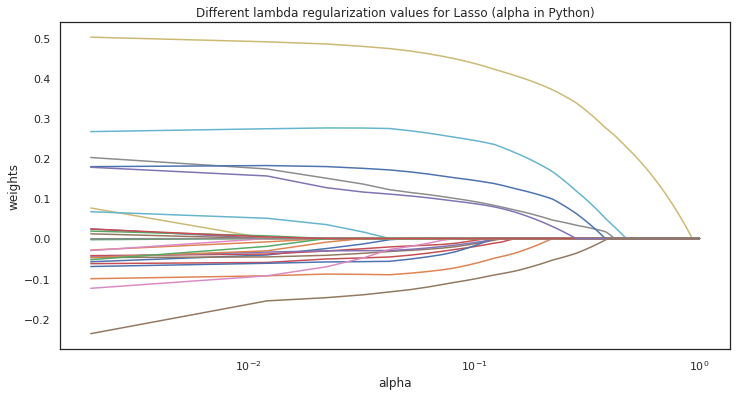

In [28]:
# Visualize regulazation path for Lasso rgression
alphas= np.linspace(0.5, 0.001, 100) 
model = Lasso(max_iter = 10000, normalize = False)
coefs = []

for a in alphas:
    model.set_params(alpha=a)
    model.fit(scale(X_train.astype(float)), y_train)
    coefs.append(model.coef_)
    
plt.figure(figsize = (12,6))   
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale("log")
plt.axis("tight")
plt.xlabel("alpha")
plt.ylabel("weights");
plt.title("Different lambda regularization values for Lasso (alpha in Python)")
plt.show()

In [29]:
# Initiate BIC and AIC alphas for Lasso regression
model_bic = LassoLarsIC(criterion = "bic", normalize = True, max_iter = 10000)
t1 = time.time()
model_bic.fit(X_train, y_train)
t_bic = time.time() - t1 
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion = "aic", normalize = True, max_iter = 10000)
model_aic.fit(X_train, y_train)
alpha_aic_ = model_aic.alpha_

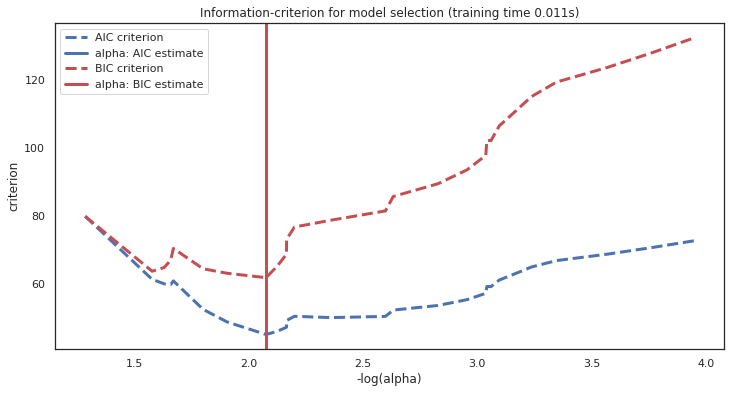

In [30]:
# Plot Aikake's and Bayesian information criterion for model selection
def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, "--", color = color,
             linewidth = 3, label = "%s criterion" % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth = 3,
                label = "alpha: %s estimate" % name)
    plt.xlabel("-log(alpha)")
    plt.ylabel("criterion")

plt.figure(figsize = (12,6))  
plot_ic_criterion(model_aic, "AIC", "b")
plot_ic_criterion(model_bic, "BIC", "r")
plt.legend()
plt.title("Information-criterion for model selection (training time %.3fs)"% t_bic);
plt.show()

In [31]:
# Print out the variables to be selected for Lasso regression model according to BIC
bic_features = pd.Series(model_bic.coef_, index = data_final_x.columns)
print("*******************************")
print("Features according to BIC")
print("-------------------------------")
print(bic_features.iloc[bic_features.nonzero()[0]])
print("\nOptimal BIC lambda: {:3f}".format(alpha_bic_))
print("*******************************")

*******************************
Features according to BIC
-------------------------------
sales_log_lag1    0.088547
DP_lag2          -0.082864
TP                1.679862
CP                0.816480
DP                0.269455
mail_campaign4    0.036126
price_log        -0.547495
dtype: float64

Optimal BIC lambda: 0.008394
*******************************


In [32]:
# Print out the variables to be selected for Lasso regression model according to AIC
aic_features = pd.Series(model_aic.coef_, index = data_final_x.columns)
print("\n")
print("*******************************")
print("Features according to AIC") 
print("-------------------------------")
print(aic_features.iloc[aic_features.nonzero()[0]])
print("\nOptimal AIC lambda: {:3f}".format(alpha_aic_))
print("*******************************")



*******************************
Features according to AIC
-------------------------------
sales_log_lag1    0.088547
DP_lag2          -0.082864
TP                1.679862
CP                0.816480
DP                0.269455
mail_campaign4    0.036126
price_log        -0.547495
dtype: float64

Optimal AIC lambda: 0.008394
*******************************


__NOTE 1:__ We can not use normal cross-validation for time series data because in time series problems the data is intrisically ordered. Hence, shuffeling the data would "brake" the order/patterns in the data.

__NOTE 2:__ Tunig the size of training and test sizes affect on the optimal AIC and BIC lambda values. E.g. changing the training and test set equal to 85 and 36, respectively, shifts the BIC and AIC lambda to approximately 0.0078 and 0.0062, respectively. Further, these changes also affect on the chosen features. 

In [33]:
# Apply Lasso regression model. Alpha: AIC
alpha = 0.008394
lasso = Lasso(max_iter = 10000, normalize = True, alpha = alpha) 
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

print("\n")
print("*************************************************************************")
print(y_pred_lasso)
print("\nMSE: {:3f}".format(mean_squared_error(y_test, y_pred_lasso)))
print("*************************************************************************")



*************************************************************************
[ 5.15791586  4.74722051  4.75639439  5.77220938  4.93420615  4.77720994
  5.04739195  5.0150729   5.81872811  6.67313371  5.3957745   5.13526664
  4.80150718  4.86898861  5.30793943  5.14219645  4.97654855  5.66677077
  5.86941982  5.18579858  5.00252581  4.8284462   5.13204202  5.30995549
  5.08392918  4.93060625  5.02342215  4.99138006  6.43271174  5.26136378
  5.14126252  5.47586378  4.86907918  4.85717955  5.6396199   5.09709936
  4.81488889  4.79502184  5.03047411  4.77536198  4.93506705]

MSE: 0.359940
*************************************************************************


### Ridge regression model


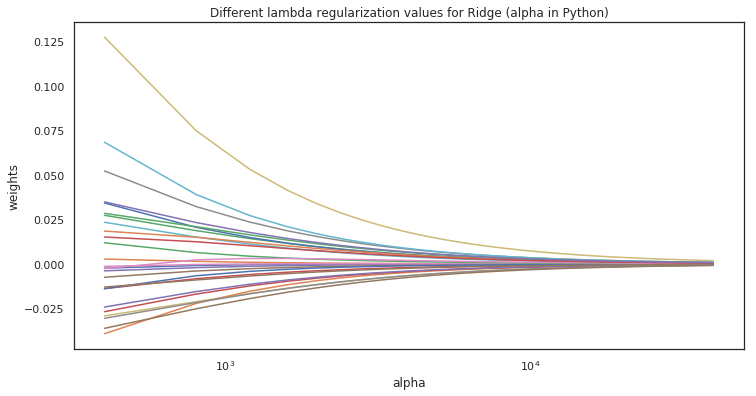

In [34]:
# Visualize regulazation path for Ridge regression
alphas= np.linspace(20000, 200, 100) 
model = Ridge(max_iter = 10000, normalize = False)
coefs = []

for a in alphas:
    model.set_params(alpha = a)
    model.fit(scale(X_train.astype(float)), y_train)
    coefs.append(model.coef_)

plt.figure(figsize = (12,6))     
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale("log")
plt.axis("tight")
plt.xlabel("alpha")
plt.ylabel("weights");
plt.title("Different lambda regularization values for Ridge (alpha in Python)")
plt.show()

- Define a Ridge regression model with the optimal BIC and AIC lambda (alpha) values

- __BIC__ = $n \times log(mse)+nvar \times log(n)$
- __AIC__ = $n \times log(mse)+2 \times nvar$

where:

- n: number of observations in the data
- nvar: number of variables included in the model
- mse: mean squared error

In [35]:
# Calculate optimal BIC ans AIC values for ridge regression according to the given formula
alpha_ridge = np.linspace(0.5, 0.001, 1000)
n = len(data_final_x)

mse_list = []
nvar_list = []
bic_list = []
aic_list = []

for i in alpha_ridge:
    ridge = Ridge(max_iter = 10000, normalize = True, alpha= i) 
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred_ridge)
    mse_list.append(mse)
    
    nvar = len(ridge.coef_.nonzero()[0])
    nvar_list.append(nvar)
    
    bic_ridge = n*np.log(mse)+nvar*np.log(n)
    bic_list.append(bic_ridge)
    
    aic_ridge = n*np.log(mse)+2*nvar
    aic_list.append(aic_ridge)
    
print("\n")
index_alpha = np.argmin(aic_list)
print("****************************")
print("Optimal AIC lambda: ", round(alpha_ridge[index_alpha],5))

index_alpha2 = np.argmin(bic_list)
print("Optimal BIC lambda: ", round(alpha_ridge[index_alpha2],5))
print("****************************")
print("\n")



****************************
Optimal AIC lambda:  0.001
Optimal BIC lambda:  0.001
****************************




In [36]:
# Apply Ridge regression model
if index_alpha <= index_alpha2:
    ridge1 = Ridge(max_iter = 10000, normalize = True, alpha = alpha_ridge[index_alpha]) 
    ridge1.fit(X_train, y_train)
    y_pred_ridge1 = ridge1.predict(X_test)
else:
    ridge1 = Ridge(max_iter = 10000, normalize = True, alpha = alpha_ridge[index_alpha2]) 
    ridge1.fit(X_train, y_train)
    y_pred_ridge1 = ridge1.predict(X_test)

print("\n")
print("*******************************")
print(pd.Series(ridge1.coef_, index = data_final_x.columns))
print("\nlambda value: {:4f} \nMSE: {:4f}".format(alpha_ridge[index_alpha], mean_squared_error(y_test, y_pred_ridge1)))
print("*******************************")



*******************************
TP_lag1               -0.273128
CP_lag1               -0.134552
DP_lag1               -0.016396
mail_campaign1_lag1   -0.029439
mail_campaign2_lag1    0.015220
mail_campaign3_lag1   -0.024423
mail_campaign4_lag1   -0.019527
sales_log_lag1         0.262307
price_log_lag1         0.730569
TP_lag2                0.288087
CP_lag2               -0.272151
DP_lag2               -0.220772
mail_campaign1_lag2    0.008723
mail_campaign2_lag2   -0.022008
mail_campaign3_lag2   -0.026199
mail_campaign4_lag2    0.012070
sales_log_lag2        -0.158064
price_log_lag2        -0.141711
TP                     2.075903
CP                     0.997544
DP                     0.380280
mail_campaign1        -0.023450
mail_campaign2        -0.026731
mail_campaign3         0.011636
mail_campaign4         0.100942
price_log             -1.686634
dtype: float64

lambda value: 0.001000 
MSE: 0.352799
*******************************


***

### Part 2g: 
### Re-estimation with OLS model and comparison between OLS and Lasso regression model

In [37]:
# Apply regular OLS model with the coefficients given by Lasso regression
ols_model = smf.ols(formula = "sales_log ~ sales_log_lag1 + DP_lag2 + TP + CP + DP + mail_campaign4 + price_log +\
                mail_campaign3_lag1", data = data_final).fit()
predictions_OLS = ols_model.predict(X_test)

print("\n")
print("***********************")
print("MSE: " + str(mean_squared_error(y_test, predictions_OLS))) 
print("***********************")
print("\n")
print(ols_model.summary())  



***********************
MSE: 0.291209468117
***********************


                            OLS Regression Results                            
Dep. Variable:              sales_log   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     23.70
Date:                Mon, 10 Jun 2019   Prob (F-statistic):           6.74e-21
Time:                        10:17:50   Log-Likelihood:                -84.793
No. Observations:                 121   AIC:                             187.6
Df Residuals:                     112   BIC:                             212.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In [38]:
# Calculate root-mean-square errors 
print("\n")
print("******************************")
print("Lasso RMSE: " + str(np.sqrt(np.mean((y_test - y_pred_lasso)**2))))
print("Ridge RMSE: " + str(np.sqrt(np.mean((y_test - y_pred_ridge1)**2))))
print("OLS RMSE: " + str(np.sqrt(np.mean((y_test - predictions_OLS)**2))))
print("******************************")

# Fetch Lasso's and OLS' variables and create a data frame
lasso_coeffs = np.insert(lasso.coef_, 0, lasso.intercept_)
lasso_coeffs = pd.DataFrame(lasso_coeffs[lasso_coeffs != 0])
ols_coeffs = ols_model.params

lasso_df = pd.DataFrame(data = lasso_coeffs.values, columns = ["Lasso"], index = ols_coeffs.index)
ols_df = pd.DataFrame(ols_coeffs, columns = ["OLS"])
comparison = pd.concat([lasso_df, ols_df], axis = 1)
comparison



******************************
Lasso RMSE: 0.599949779504
Ridge RMSE: 0.593969191099
OLS RMSE: 0.539638275252
******************************


,Lasso,OLS
Intercept,4.034712,3.599905
sales_log_lag1,-0.000003,0.124633
DP_lag2,0.088532,-0.146552
TP,-0.082848,2.072639
CP,1.679906,1.243194
DP,0.816522,0.621458
mail_campaign4,0.269484,0.052505
price_log,0.036127,-0.838211
mail_campaign3_lag1,-0.547519,-0.027878


As we can observe, the OLS-fitted linear model gives a slightly lower residual root-mean-square error than the Lasso, but this is not suprising as ordinary least squares minimizes square errors unlike Lasso regression.

It would also seem that in general the absolute value of OLS' coefficients are different than those of their counterparts produced by the Lasso regression model. The coefficients produced by the OLS model seem to be pushed further to the extremes indicating that Lasso coefficients are likely to give better results on the testing dataset.

In [39]:
# Create a new dataframe for plotting
data = {"y_pred_lasso":y_pred_lasso, "y_regular_OLS": predictions_OLS, "y_pred_ridge1":y_pred_ridge1, "y_test": y_test,}
pred_df = pd.DataFrame(data = data)
pred_df.head()

,y_pred_lasso,y_regular_OLS,y_pred_ridge1,y_test
82,5.157916,5.351222,5.421491,5.258126
83,4.747221,4.468674,4.608292,4.051877
84,4.756394,4.596177,4.563168,5.036480
85,5.772209,5.955528,6.072482,5.797868
86,4.934206,4.763180,4.722351,4.769030


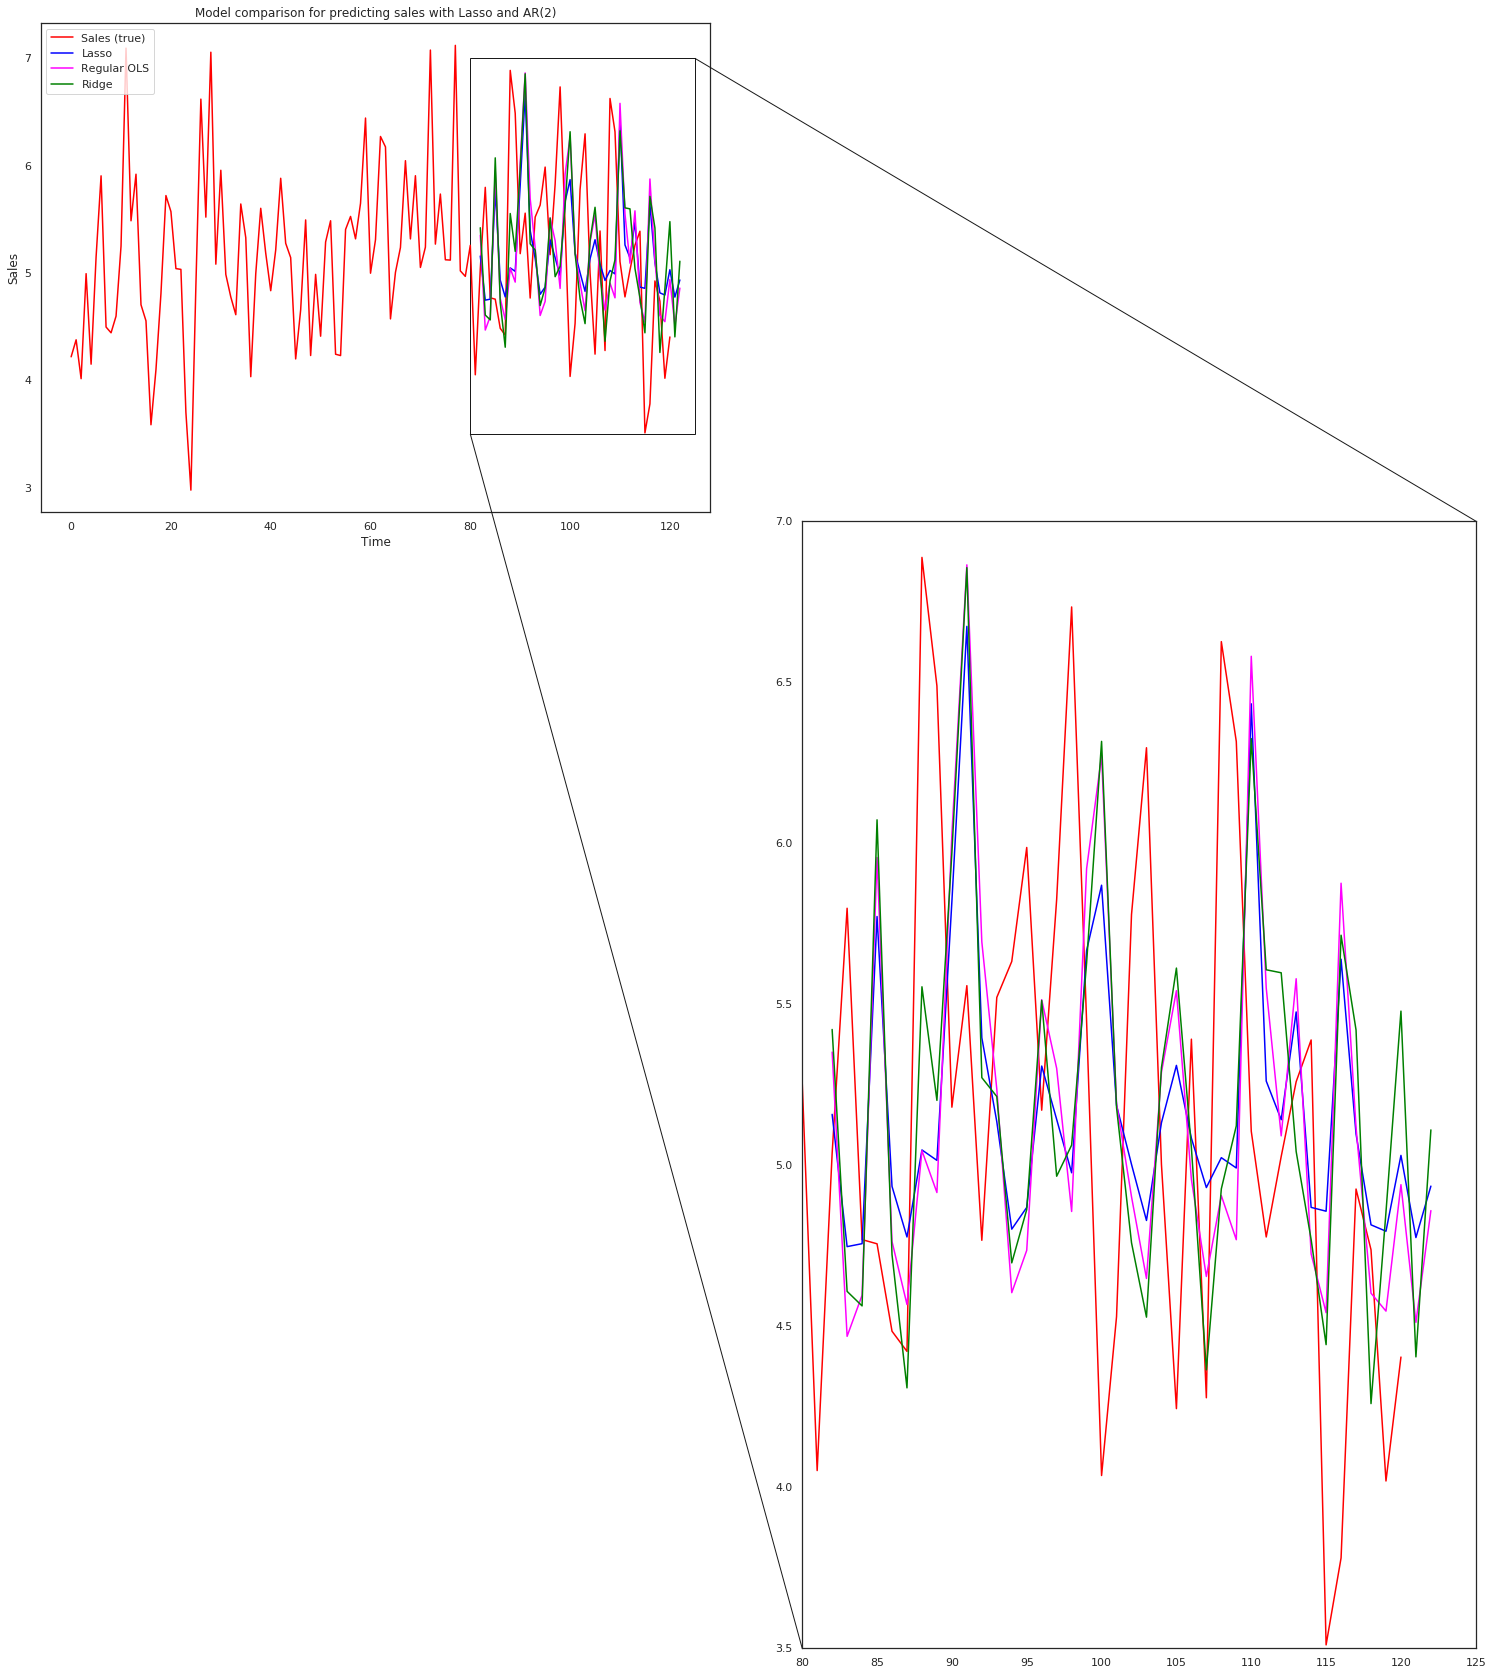

In [40]:
# Spesicy data for the main plot
fig, ax = plt.subplots(figsize = (12, 9))
ax.plot(y, label = "Sales (true)", c = "red")
ax.plot(pred_df["y_pred_lasso"], label = "Lasso", c = "blue")
ax.plot(pred_df["y_regular_OLS"], label = "Regular OLS", c = "magenta")
ax.plot(pred_df["y_pred_ridge1"], label = "Ridge", c = "green")
ax.set_title("Model comparison for predicting sales with Lasso and AR(2)")
ax.set_xlabel("Time")
ax.set_ylabel("Sales")
ax.legend(loc="upper left")

# Spesicy the zoomed window
axins = zoomed_inset_axes(ax, 3, loc = 2, bbox_to_anchor = (1.0, 0.12), bbox_transform = ax.figure.transFigure)
axins.plot(y, label = "Sales (true)", c = "red")
axins.plot(pred_df["y_pred_lasso"], label = "Lasso", c = "blue")
axins.plot(pred_df["y_regular_OLS"], label = "Regular OLS", c = "magenta")
axins.plot(pred_df["y_pred_ridge1"], label = "Ridge", c = "green")

axins.axis([80, 125, 3.5, 7.0])
mark_inset(ax, axins, loc1 = 1, loc2 = 3, fc = "none", ec = "0.1")

plt.show()

This plot shows that Lasso and OLS do the best job in following the true sales pattern while RIdge regression model is clearly underperfoming in comparison to the other two models.

***

### Part 2h: 
### Which campaigns to run for the next four weeks

Below an extended dataframe for simulating which campaigns to run for the next four weeks. These variables can be interpreted as our decision on how to plan our sales. For example, here I have set the most mail campaigns at site 4 because based on the Lasso coefficients they seems to be the best positive driver for sales. On the other hand, the mail campaigns at site 3 seem to have a negative impact on sales which is why I have set its values to zero. 

In [41]:
simulation_4_weeks = {"TP": [0,1,0,0],
                      "CP": [1,0,1,0],
                      "DP": [0,0,0,1],
                      "mail_campaign1": [1,5,2,7],
                      "mail_campaign2": [3,1,6,2],
                      "mail_campaign3": [0,0,0,0],
                      "mail_campaign4": [4,6,8,10],
                      "price_log": np.log([0.587, 0.587, 0.576, 0.610]),
                      "sales_log": ["NaN", "NaN", "NaN", "NaN"],
                      "week" : [123,124,125,126]}

df_4 = pd.DataFrame(data = simulation_4_weeks, index = simulation_4_weeks["week"]).astype("float64")
sim_df = pd.concat([df,df_4])
sim_df.drop(["price", "sales"], axis = 1, inplace = True)
print(sim_df.shape)
sim_df.tail(10)

(127, 10)


,CP,DP,TP,mail_campaign1,mail_campaign2,mail_campaign3,mail_campaign4,price_log,sales_log,week
117,0.0,0.0,0.0,6.0,4.0,5.0,8.0,-0.541150,3.510654,117.0
118,0.0,0.0,0.0,5.0,4.0,6.0,5.0,-0.527387,3.780571,118.0
119,0.0,0.0,0.0,2.0,4.0,4.0,3.0,-0.579416,4.926037,119.0
120,0.0,0.0,0.0,6.0,4.0,6.0,7.0,-0.560290,4.737477,120.0
121,0.0,0.0,0.0,3.0,3.0,2.0,1.0,-0.520750,4.019532,121.0
122,0.0,0.0,0.0,5.0,7.0,6.0,7.0,-0.532620,4.404319,122.0
123,1.0,0.0,0.0,1.0,3.0,0.0,4.0,-0.532730,NaN,123.0
124,0.0,0.0,1.0,5.0,1.0,0.0,6.0,-0.532730,NaN,124.0
125,1.0,0.0,0.0,2.0,6.0,0.0,8.0,-0.551648,NaN,125.0
126,0.0,1.0,0.0,7.0,2.0,0.0,10.0,-0.494296,NaN,126.0


### Reference Lasso coefficients

In [42]:
# A reference for the below linear regression function
comparison

,Lasso,OLS
Intercept,4.034712,3.599905
sales_log_lag1,-0.000003,0.124633
DP_lag2,0.088532,-0.146552
TP,-0.082848,2.072639
CP,1.679906,1.243194
DP,0.816522,0.621458
mail_campaign4,0.269484,0.052505
price_log,0.036127,-0.838211
mail_campaign3_lag1,-0.547519,-0.027878


In [43]:
# Create a function for a linear regression model

def linear_regression(lasso_intercept, lasso_coeffs, sim_df, sigma):
    
    N = sim_df.shape[0]
    y = sim_df["sales_log"]
    e = np.random.normal(size = N, scale = sigma)
    for t in range(123, N): 
        y[t] = lasso_intercept + lasso_coeffs["sales_log_lag1"] * sim_df["sales_log"][t-1] +\
        lasso_coeffs["DP_lag2"] * sim_df["DP"][t-2] +\
        lasso_coeffs["TP"] * sim_df["TP"][t] +\
        lasso_coeffs["CP"] * sim_df["CP"][t] +\
        lasso_coeffs["DP"] * sim_df["DP"][t] +\
        lasso_coeffs["mail_campaign4"] * sim_df["mail_campaign4"][t-1] +\
        lasso_coeffs["price_log"] * sim_df["price_log"][t] +\
        lasso_coeffs["mail_campaign3_lag1"] * sim_df["mail_campaign3"][t-1] +\
        e[t]
        
    return y

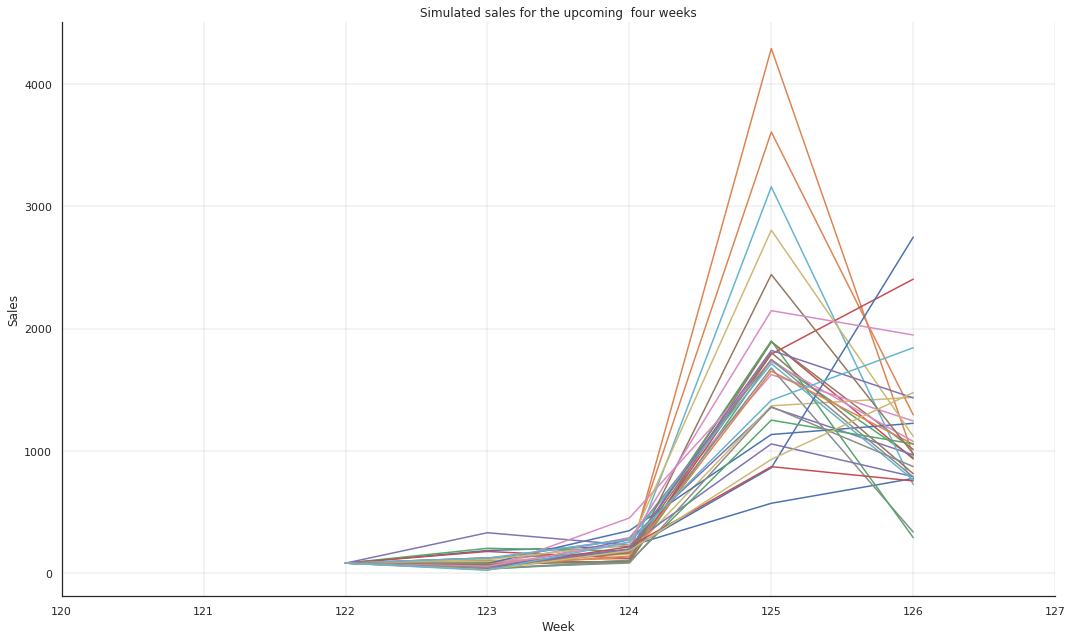

In [51]:
fig, ax = plt.subplots(figsize =  (15,9))

# By taking the exponent of sales, we can convert the log-transformed sales data in to its original format
ax.set_xlim(120, 127)
ax.set_title("Simulated sales for the upcoming  four weeks")
ax.set_ylabel("Sales")
ax.set_xlabel("Week")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(color = "grey", linestyle = "-", linewidth = 0.2, alpha = 0.9)

simulations = 30
for i in range(0, simulations):
    sim_sales = linear_regression(lasso_df.loc["Intercept", "Lasso"], lasso_df.iloc[1:, 0],\
                                  sim_df, np.sqrt(ols_model.scale))
    
    plt.plot([122, 123, 124, 125, 126],  np.exp(sim_sales[122:]))

plt.tight_layout()   
plt.show()

***

### End notes

The above graph displays the simulated sales forecast for the next 4 weeks. The data entries for the simulations were manually given <a href ="#Which-campaigns-to-run-for-the-next-four-weeks" > HERE </a> and the coefficients were computed by using Lasso regression <a href = "#Reference-Lasso-coefficients" > HERE </a>

Note that these simulations can vary according to the given data entries for the simulations. This allows the user to test different marketing strategies etc. to see how they affect on sales for the upcoming four weeks.